In [1]:
%cd /content
!git clone -b dev https://github.com/camenduru/InternLM-XComposer
!pip install -q lida llmx gradio https://github.com/camenduru/LLaVA/releases/download/v1.1.3/llava-ShareGPT4V-1.1.3-py3-none-any.whl
%cd /content/InternLM-XComposer/projects/ShareGPT4V
!pip install -q gradio .
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch
from llava.model.builder import load_pretrained_model
model_path = "4bit/ShareGPT4V-7B-5GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
# model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
# tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model_name = "llava-v1.5-7b"
tokenizer, model, image_processor, context_len = load_pretrained_model("4bit/ShareGPT4V-7B-5GB", None, "llava-v1.5-7b", True, False)
vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

import os
import requests
from PIL import Image
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image_file, prompt):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

/content
Cloning into 'InternLM-XComposer'...
remote: Enumerating objects: 657, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 657 (delta 165), reused 212 (delta 115), pack-reused 362
Receiving objects: 100% (657/657), 10.73 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (354/354), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.6 MB/s eta

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/4.24G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at 4bit/ShareGPT4V-7B-5GB were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.10.mlp.fc2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.6.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.12.self_attn.v_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.10.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.17.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.2.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.3.self_attn.v_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.3.layer_norm1.bias', 'model.vision_tower.vision_tower.

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/607M [00:00<?, ?B/s]

The image is a collage of four distinct photos, each featuring a different driver. 

In the top left, we see a man donned in a vibrant red cap, emblazoned with the word "Canon". His gaze is directed towards the left, suggesting he might be looking at something or someone out of frame.

Moving to the top right, we encounter another man, this time wearing a white cap. The word "Bosch" is prominently displayed on his cap. He too is looking to the left, mirroring the action of the man in the red cap.

The bottom left photo introduces us to a driver wearing a blue cap with the word "Compact" written on it. He is looking directly at the camera, his attention focused on the lens.

Finally, in the bottom right photo, we see a man in a black cap with the word "Williams" written on it. He too is looking directly at the camera, his expression neutral.

Each driver is captured in a moment of stillness, their expressions serious and focused. The collage as a whole paints a picture of intense concen

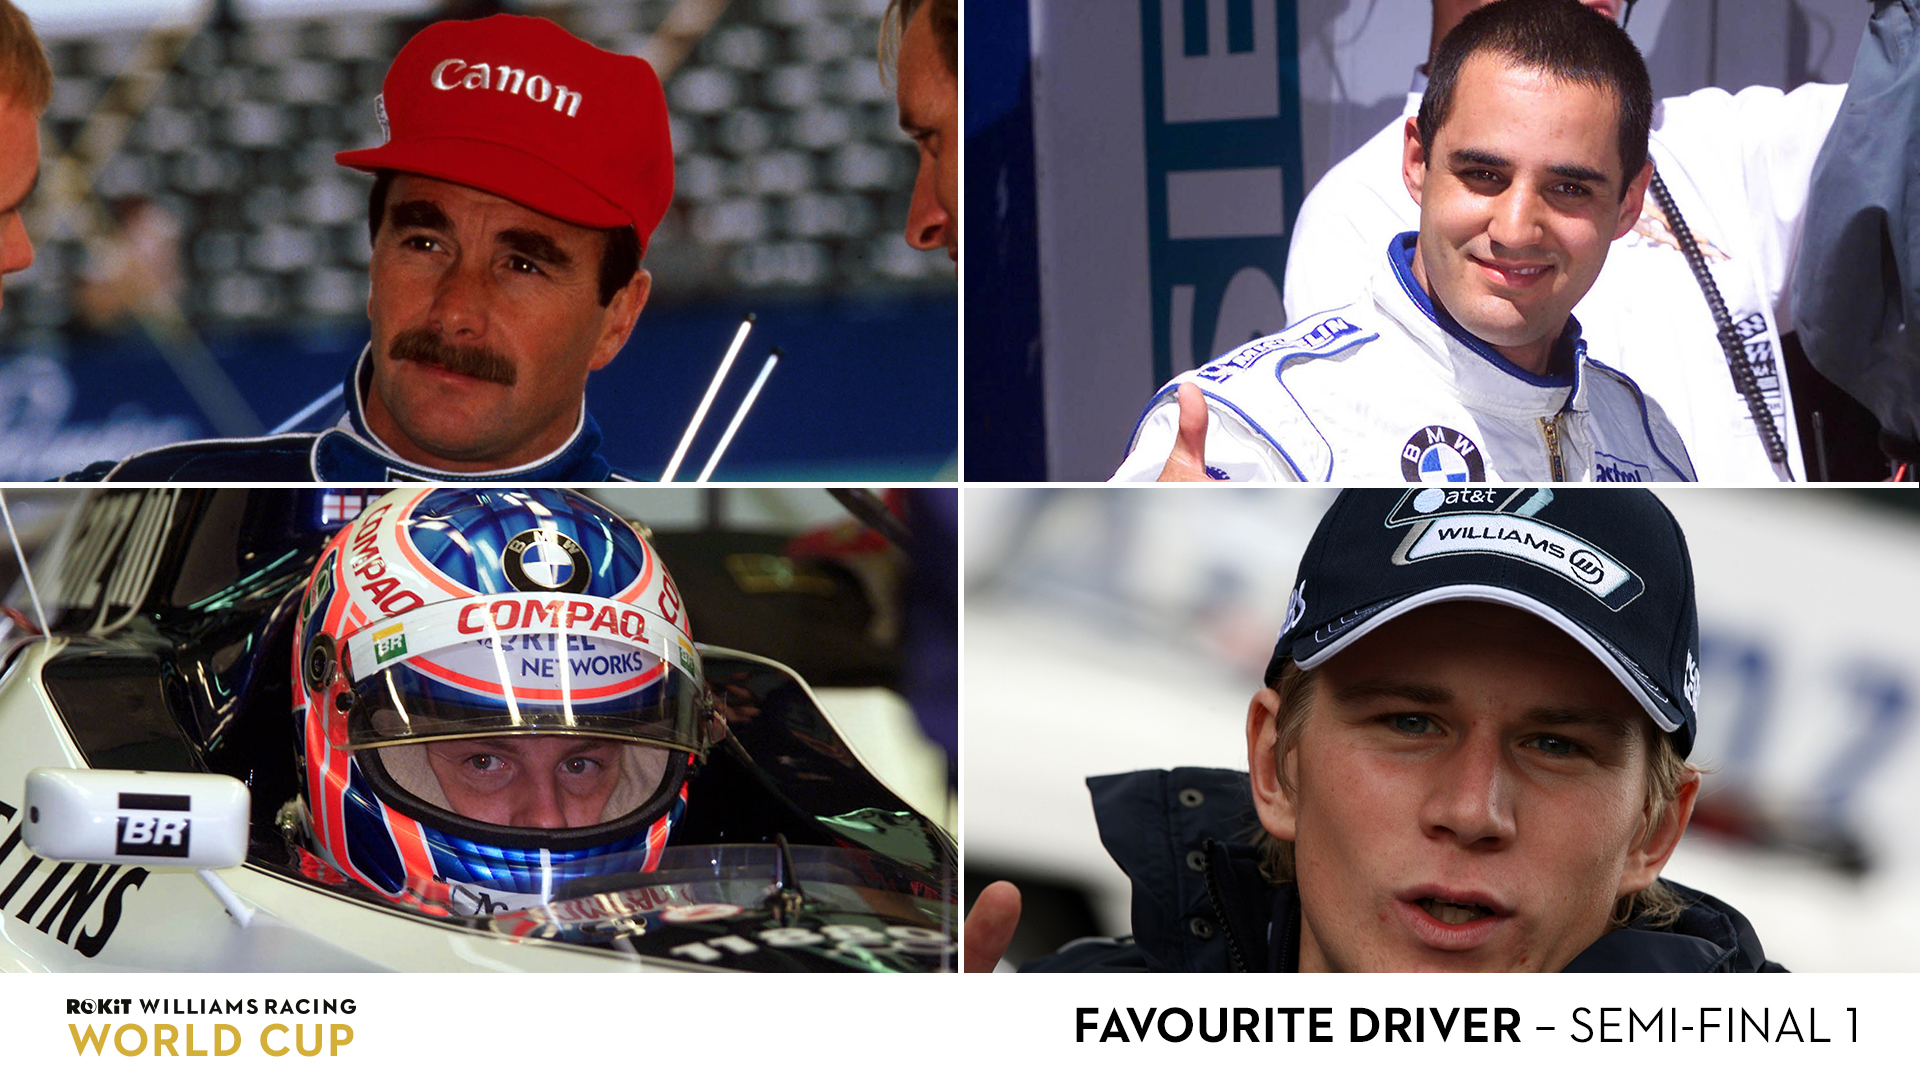

In [2]:
image, output = caption_image(f'https://pbs.twimg.com/media/EUBrvqeWoAAo8qL?format=jpg&name=large', 'Describe the image and color details.')
print(output)
image